# Avocado pricing prediction
We have manually uploaded the csv file into the notebook environment. However, we would like to persist our experiment results and to share them with the rest of the team. The recommended way of doing it in SAP DI is creating an artifact. We can easily do it from Jupyter by leveraging `sapdi` library.

In [1]:
import sapdi
from sapdi.artifact.artifact import ArtifactKind


artifact = sapdi.create_artifact(description="Avocado prices dataset", artifact_name="Avocado", artifact_kind=ArtifactKind.DATASET)

with artifact.add_file(file_name='avocado.csv').get_writer() as dl_file:
    dl_file.write(open("avocado.csv").read())

Now we can read our `csv` file into a Pandas dataframe. Pandas is preinstalled for us. So, we just need to import it. Let's read the artifact that we have created in the previous step. To reference it we require to provide an id. You can always find all artifacts in Datasets section of Scenario Manager. Here we just take it directly from the `artifact` object.

In [2]:
import io
import pandas as pd


artifact = sapdi.get_artifact(artifact_id=artifact.artifact_id)
file_handler = artifact.open_file(file_name='avocado.csv')
avocado_df = pd.read_csv(io.BytesIO(file_handler.read()))
avocado_df

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


In this example we are going to predict the average price based on date. Let's get rid of the redundant columns and fix dtypes.

In [3]:
avocado_df = avocado_df.drop(['4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'Unnamed: 0'], axis=1)

The price might depend on a year, month or week day. Let's create the corresponding columns.

In [4]:
filter = avocado_df['type'] == 'conventional'
prices_df = avocado_df.where(filter).groupby('Date').agg({'AveragePrice':'mean'}).reset_index()

prices_df['Date'] = pd.to_datetime(prices_df['Date'], format='%Y-%m-%d')
prices_df['Weekday'] = prices_df.apply(lambda row: row['Date'].weekday(), axis=1)
prices_df['Month'] = prices_df.apply(lambda row: row['Date'].month, axis=1)
prices_df['Day'] = prices_df.apply(lambda row: row['Date'].day, axis=1)
prices_df['Timestamp'] = prices_df.apply(lambda row: row['Date'].timestamp(), axis=1)
prices_df['Year'] = prices_df.apply(lambda row: row['Date'].year, axis=1)
prices_df = prices_df.sort_values(by=['Date'])

prices_df

,Date,AveragePrice,Weekday,Month,Day,Timestamp,Year
0,2015-01-04,1.009630,6,1,4,1.420330e+09,2015
1,2015-01-11,1.111296,6,1,11,1.420934e+09,2015
2,2015-01-18,1.133519,6,1,18,1.421539e+09,2015
3,2015-01-25,1.115370,6,1,25,1.422144e+09,2015
4,2015-02-01,0.962037,6,2,1,1.422749e+09,2015
...,...,...,...,...,...,...,...
164,2018-02-25,1.141111,6,2,25,1.519517e+09,2018
165,2018-03-04,1.142407,6,3,4,1.520122e+09,2018
166,2018-03-11,1.136667,6,3,11,1.520726e+09,2018
167,2018-03-18,1.096296,6,3,18,1.521331e+09,2018


Now we can investigate how average prices change over time

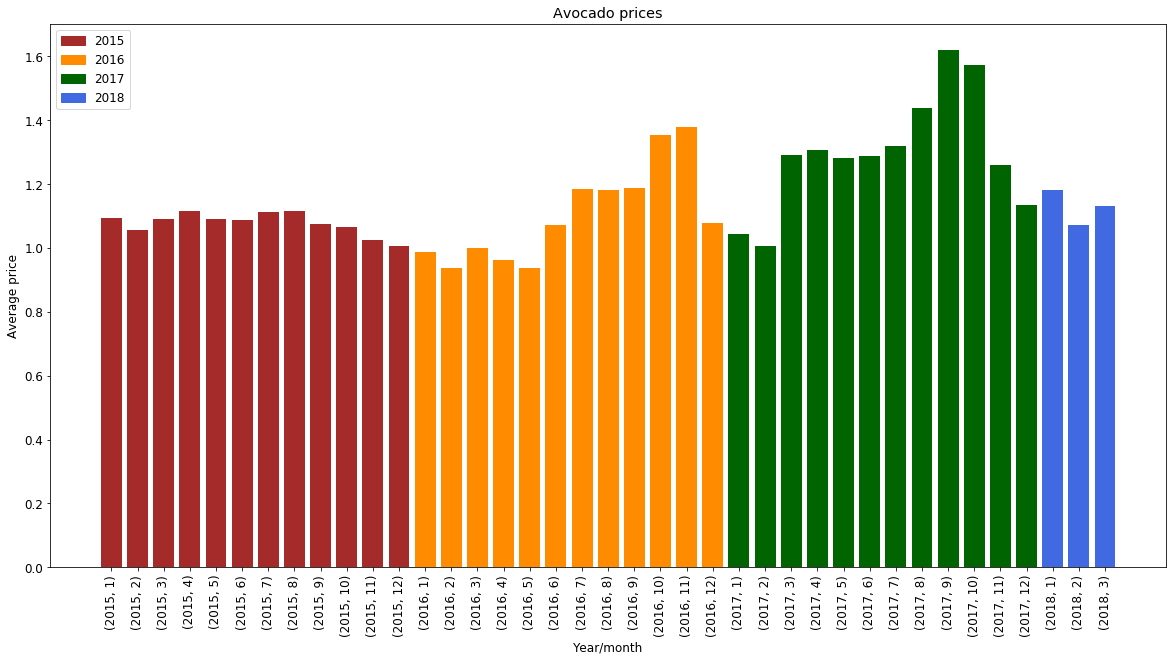

In [14]:
import matplotlib.pyplot as plt


year_month_avg = prices_df.groupby(['Year', 'Month'])['AveragePrice'].mean()

months = list(year_month_avg.keys())
avg_values = list(year_month_avg)

colors = {2015: 'brown', 2016: 'darkorange', 2017: 'darkgreen', 2018: 'royalblue'}
legend_rect = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors.values()]
legend_labels = [str(year) for year in colors.keys()]

year_colors = [colors[year_month[0]] for year_month in months]
months_str = [str(month) for month in months]

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["font.size"] = 12

plt.bar(months_str, avg_values, color=year_colors)
plt.xticks(range(0, len(months)), rotation=90)

plt.ylabel('Average price')
plt.xlabel('Year/month')
plt.title('Avocado prices')
plt.legend(legend_rect, legend_labels, loc=2)

We are going to predict a price two weeks ahead. To do it let's introduce lag columns.

In [6]:
shift2_df = prices_df.shift(2).loc[:, ['AveragePrice']].rename(columns={'AveragePrice': 'AvgPrice2'})
shift3_df = prices_df.shift(3).loc[:, ['AveragePrice']].rename(columns={'AveragePrice': 'AvgPrice3'})
shift4_df = prices_df.shift(4).loc[:, ['AveragePrice']].rename(columns={'AveragePrice': 'AvgPrice4'})

prices_shift_df = pd.concat([prices_df, shift2_df, shift3_df, shift4_df], axis=1, sort=False)
prices_shift_df = prices_shift_df.iloc[4:]

prices_shift_df

,Date,AveragePrice,Weekday,Month,Day,Timestamp,Year,AvgPrice2,AvgPrice3,AvgPrice4
4,2015-02-01,0.962037,6,2,1,1.422749e+09,2015,1.133519,1.111296,1.009630
5,2015-02-08,1.030370,6,2,8,1.423354e+09,2015,1.115370,1.133519,1.111296
6,2015-02-15,1.129074,6,2,15,1.423958e+09,2015,0.962037,1.115370,1.133519
7,2015-02-22,1.099815,6,2,22,1.424563e+09,2015,1.030370,0.962037,1.115370
8,2015-03-01,1.036852,6,3,1,1.425168e+09,2015,1.129074,1.030370,0.962037
...,...,...,...,...,...,...,...,...,...,...
164,2018-02-25,1.141111,6,2,25,1.519517e+09,2018,1.046667,0.925556,1.171296
165,2018-03-04,1.142407,6,3,4,1.520122e+09,2018,1.172222,1.046667,0.925556
166,2018-03-11,1.136667,6,3,11,1.520726e+09,2018,1.141111,1.172222,1.046667
167,2018-03-18,1.096296,6,3,18,1.521331e+09,2018,1.142407,1.141111,1.172222


Now we need to divide our dataset into the train and test dataframes. 

In [7]:
import numpy as np


np.random.seed(0) 
split_mask = np.random.rand(len(prices_shift_df)) < 0.8

x_df = prices_shift_df.loc[:, ['Weekday', 'Month', 'Day', 'Timestamp', 'Year', 'AvgPrice2', 'AvgPrice3', 'AvgPrice4']]
y_df = prices_shift_df.loc[:, ['AveragePrice']]

x_train = x_df[split_mask]
x_test = x_df[~split_mask]
y_train = y_df[split_mask]
y_test = y_df[~split_mask]

To train a model we are going to use `xgboost` library which depends on `sklearn`. Let's install both into our Jupyter envorinment. 

In [8]:
!pip install --user scikit-learn==0.22.2.post1 xgboost==1.0.2

In [9]:
from xgboost import XGBRegressor


model = XGBRegressor(max_depth=10, n_estimators=1000, seed=0)
model.fit(x_train, y_train, eval_metric="rmse", eval_set=[(x_train, y_train), (x_test, y_test)], early_stopping_rounds=10)

[0]	validation_0-rmse:0.48775	validation_1-rmse:0.47916
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.35130	validation_1-rmse:0.34473
[2]	validation_0-rmse:0.25543	validation_1-rmse:0.25306
[3]	validation_0-rmse:0.18706	validation_1-rmse:0.18539
[4]	validation_0-rmse:0.13876	validation_1-rmse:0.14108
[5]	validation_0-rmse:0.10349	validation_1-rmse:0.11207
[6]	validation_0-rmse:0.07871	validation_1-rmse:0.09111
[7]	validation_0-rmse:0.05980	validation_1-rmse:0.08170
[8]	validation_0-rmse:0.04610	validation_1-rmse:0.07420
[9]	validation_0-rmse:0.03563	validation_1-rmse:0.07089
[10]	validation_0-rmse:0.02796	validation_1-rmse:0.07142
[11]	validation_0-rmse:0.02216	validation_1-rmse:0.07135
[12]	validation_0-rmse:0.01772	validation_1-rmse:0.07031
[13]	validation_0-rmse:0.01445	validation_1-rmse:0.07046
[14]	validation_0-rmse:0.01179	validation_1-rmse:0.07

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=0, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [10]:
predicted_prices_df = prices_shift_df.loc[:, ['Date', 'AveragePrice', 'Weekday', 'Month', 'Day', 'Timestamp', 'Year', 'AvgPrice2', 'AvgPrice3', 'AvgPrice4']]
predicted_prices_df = predicted_prices_df.sort_values(by=['Date'])
predicted_prices_df['PredictedAvgPrice'] = model.predict(prices_shift_df.loc[:, ['Weekday', 'Month', 'Day', 'Timestamp', 'Year', 'AvgPrice2', 'AvgPrice3', 'AvgPrice4']])

In [11]:
from datetime import timedelta, datetime


start_date = predicted_prices_df['Date'].iloc[-1]
date = start_date + timedelta(days=7)
end_date = datetime(year=2019, month=9, day=1)
new_dates_df = predicted_prices_df.iloc[-7:]


while date < end_date:    
    new_values = {
        'Date': date, 
        'AveragePrice': np.nan, 
        'Weekday': date.weekday(), 
        'Month': date.month, 
        'Day': date.day, 
        'Timestamp': date.timestamp(), 
        'Year': date.year, 
        'AvgPrice2': new_dates_df['AveragePrice'].iloc[-2],
        'AvgPrice3': new_dates_df['AveragePrice'].iloc[-3],
        'AvgPrice4': new_dates_df['AveragePrice'].iloc[-4],
        'PredictedAvgPrice': np.nan
    }
    new_dates_df = new_dates_df.append(new_values, ignore_index=True)
    prediction = model.predict(
        new_dates_df.loc[:, ['Weekday', 'Month', 'Day', 'Timestamp', 'Year', 'AvgPrice2', 'AvgPrice3', 'AvgPrice4']].iloc[-1:])
    new_dates_df.iloc[-1, new_dates_df.columns.get_loc('AveragePrice')] = prediction
    new_dates_df.iloc[-1, new_dates_df.columns.get_loc('PredictedAvgPrice')] = prediction
    date = date + timedelta(days=7)

    
new_dates_df = new_dates_df.iloc[6:]
new_dates_df

,Date,AveragePrice,Weekday,Month,Day,Timestamp,Year,AvgPrice2,AvgPrice3,AvgPrice4,PredictedAvgPrice
6,2018-03-25,1.147222,6,3,25,1.521936e+09,2018,1.136667,1.142407,1.141111,1.225054
7,2018-04-01,1.013035,6,4,1,1.522541e+09,2018,1.096296,1.136667,1.142407,1.013035
8,2018-04-08,1.078440,6,4,8,1.523146e+09,2018,1.147222,1.096296,1.136667,1.078440
9,2018-04-15,1.219283,6,4,15,1.523750e+09,2018,1.013035,1.147222,1.096296,1.219283
10,2018-04-22,1.127450,6,4,22,1.524355e+09,2018,1.078440,1.013035,1.147222,1.127450
...,...,...,...,...,...,...,...,...,...,...,...
76,2019-07-28,1.298931,6,7,28,1.564272e+09,2019,1.311798,1.213641,1.268603,1.298931
77,2019-08-04,1.140102,6,8,4,1.564877e+09,2019,1.216294,1.311798,1.213641,1.140102
78,2019-08-11,1.184907,6,8,11,1.565482e+09,2019,1.298931,1.216294,1.311798,1.184907
79,2019-08-18,1.205615,6,8,18,1.566086e+09,2019,1.140102,1.298931,1.216294,1.205615


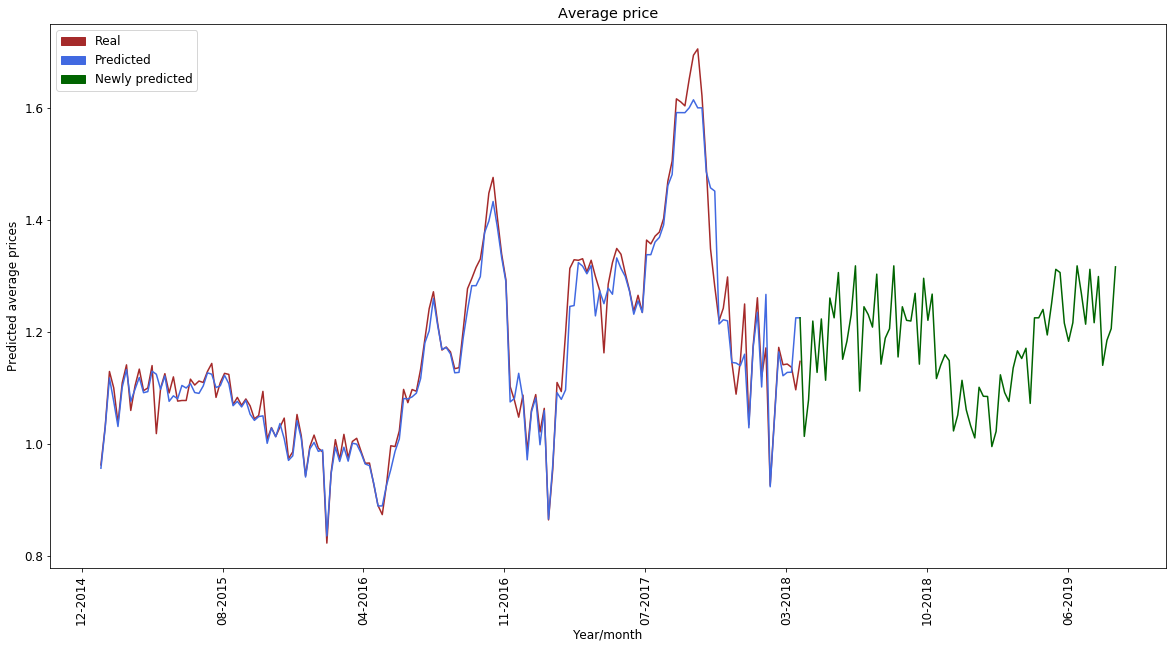

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

colors = {'Real': 'brown', 'Predicted': 'royalblue', 'Newly predicted': 'darkgreen'}
legend_rect = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors.values()]
legend_labels = [str(year) for year in colors.keys()]

ax1.plot(predicted_prices_df['Timestamp'], predicted_prices_df['AveragePrice'], color=colors['Real'])
ax1.plot(predicted_prices_df['Timestamp'], predicted_prices_df['PredictedAvgPrice'], c=colors['Predicted'])
ax1.plot(new_dates_df['Timestamp'], new_dates_df['PredictedAvgPrice'], c=colors['Newly predicted'])


labels = ax1.get_xticks().tolist()
labels = [datetime.fromtimestamp(timestamp).strftime("%m-%Y") for timestamp in labels]
ax1.set_xticklabels(labels, rotation=90)

plt.ylabel('Predicted average prices')
plt.xlabel('Year/month')
plt.title('Average price')
plt.legend(legend_rect, legend_labels, loc=2)

Let's now persist our model and create an artifact out of it.

In [13]:
import pickle


artifact = sapdi.create_artifact(description="Avocado forecast model", artifact_name="GBR_Model", artifact_kind=ArtifactKind.MODEL)

with artifact.add_file(file_name='model.pkl').get_writer() as dl_file:
    pickle.dump(model, dl_file)